### 10.2 Chuỗi sang chuỗi áp dụng cơ chế tập trung

- Trong phần này, chúng ta thêm cơ chế tập trung vào mô hình chuỗi sang chuỗi để gộp các trạng thái theo trọng số tương ứng một cách tường minh. Hình dưới mô tả kiến trúc mô hình thực hiện mã hóa và giải mã tại bước thời gian t.
- Bộ nhớ của tầng tập trung ở đây bao gồm tất cả các thông tin mà bộ mã hóa được học - đầu ra của bộ nhớ tại từng bước thời gian. 
- Trong quá trình giải mã, đầu ra của bộ giải mã tại bước thời gian trước đó t - 1 được sử dụng làm câu truy vấn. 
- __Đầu ra của mô hình tập trung có thể hiểu là thông tin ngữ cảnh của chuỗi, phần ngữ cảnh này được ghép nối vào bộ giải mã D_t và kết quả được được đưa vào bộ giải mã.

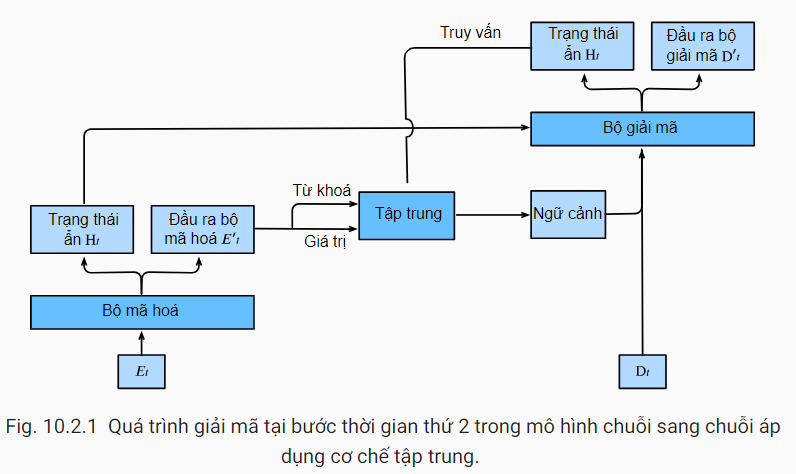

- Để minh họa kiến trúc tổng thể của mô hình seq2seq áp dụng cơ chế tập trung, cấu trúc tầng của bộ mã hóa và bộ giải mã được mô tả trong hình sau:

    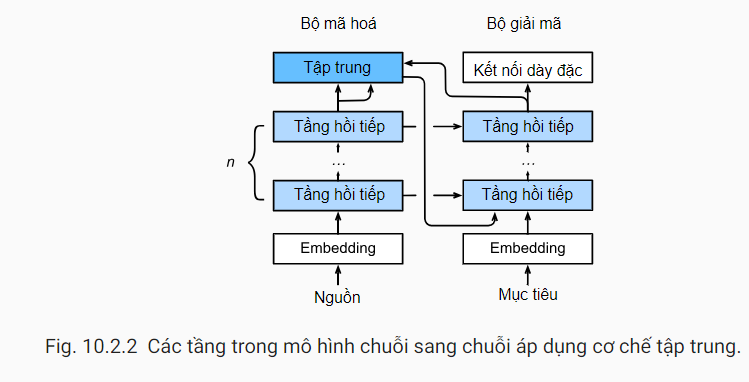

In [1]:
from d2l import torch as d2l
from torch import nn
import numpy as np
from torch.nn import functional as F

### 10.2.1 Bộ giải mã
- Do bộ mã hóa của mô hình seq2seq áp dụng cơ chế tập trung giống với bộ mã hóa của Seq2SeqEncoder nên ta sẽ chỉ tập trung vào bộ giải mã. Ta thêm một tầng tập trung MLP (MLPAttention) có cùng kích thước tầng ẩn với tầng LSTM trong bộ giải mã. Sau đó, ta khởi tạo trạng thái của bộ giải mã bằng cách truyền vào ba đầu ra thu được từ bộ mã hóa:
    1. __Đầu ra của bộ mã hóa tại tất cả các bước thời gian__: Được sử dụng như bộ nhớ của tầng tập trung có cùng các khóa và giá trị.
    2. __Trạng thái ẩn của bộ mã hóa tại bước thời gian cuối cùng__: Được sử dụng làm trạng thái ẩn ban đầu của bộ giải mã.
    3. __Độ dài hợp lệ của bộ mã hóa__: Để tầng tập trung có thể bỏ qua những token đệm có trong đầu ra của bộ mã hóa.

- Ở mỗi bước thời gian trong quá trình giải mã, ta sử dụng trạng thái ẩn của tầng RNN cuối cùng làm câu truy vấn cho tầng tập trung.
- Đầu ra của mô hình tập trung sau đó được ghép nối với vector embedding đầu vào để đưa vào tầng RNN. 
- Mặc dù trạng thái ẩn của tầng RNN cũng chứa thông tin từ bộ giải mã ở các bước thời gian trước đó nhưng đầu ra của tầng tập trung sẽ lựa chọn các đầu ra của bộ mã hóa một cách tường minh bằng cách loại bỏ những thông tin không liên quan.


In [ ]:
class Seq2SeqAttentionDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout = 0):
        super().__init__()
        self.attention_cell = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding_cell = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout = dropout)
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_len):
        outputs, hidden_state = enc_outputs
        # output shape: (seq_len, batch_size, num_hiddens)
        return (outputs.swapaxes(0, 1), hidden_state, enc_valid_len)
    
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_len = state
        X = self.embedding(X).swapaxes(0, 1) # (seq_len, batch_size, embed_size)

        outputs = []

        for x in X:
            # quuery shape: (bach_size, 1, num_hiddens)